# Survival analysis learning example

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

In [12]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize']=(15,7)

In [31]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                  bool
dtype: object

In [40]:
churn_data = pd.read_csv('datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# transform tenure and churn features
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'],errors='coerce')
churn_data=churn_data.dropna()
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


In [41]:
# fitting kmf to churn data
t = churn_data['tenure'].values
churn = churn_data["Churn"].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')# plotting kmf curve

<lifelines.KaplanMeierFitter: fitted with 7032 observations, 5163 censored>

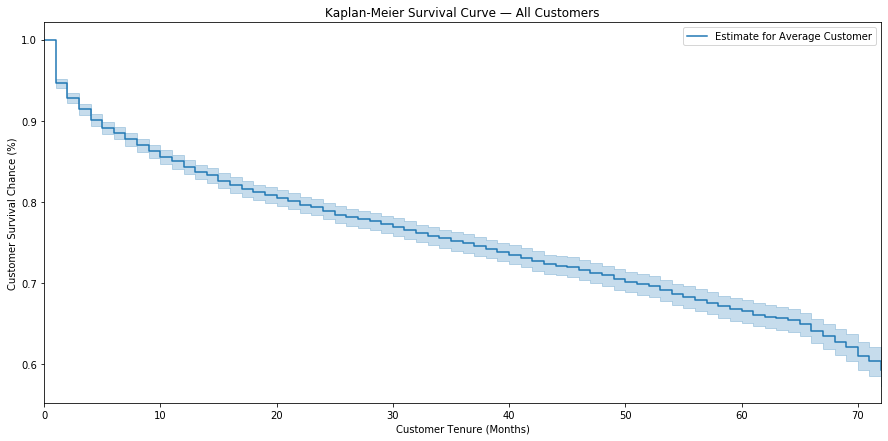

In [42]:
fig, ax = plt.subplots()
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [57]:
(churn_data == '').sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [64]:
churn_data['PhoneService'].value_counts()

Yes    6352
No      680
Name: PhoneService, dtype: int64

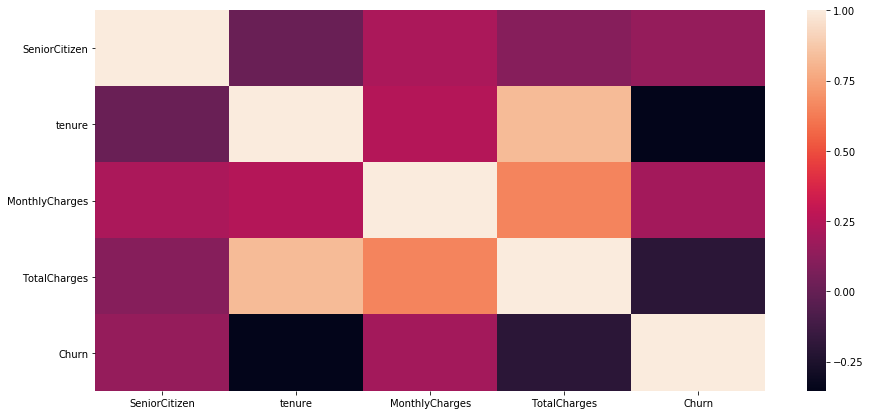

In [61]:
sns.heatmap(churn_data.corr())

In [71]:
features_to_drop = ['customerID','PhoneService']  # Drop phone service due to colinearity with feature MultipleLines-NoService
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard = churn_data.drop(features_to_drop, axis=1).copy()

# convert some stuff to integers
churn_hazard['TotalCharges'] = pd.to_numeric(churn_hazard['TotalCharges'], errors='coerce')
churn_hazard['TotalCharges'].fillna(0, inplace=True)

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV','StreamingMovies', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'

churn_hazard['gender'] = churn_hazard['gender'] == 'Female'
    
# let's one hot encode the remaining categorical features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod','InternetService']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

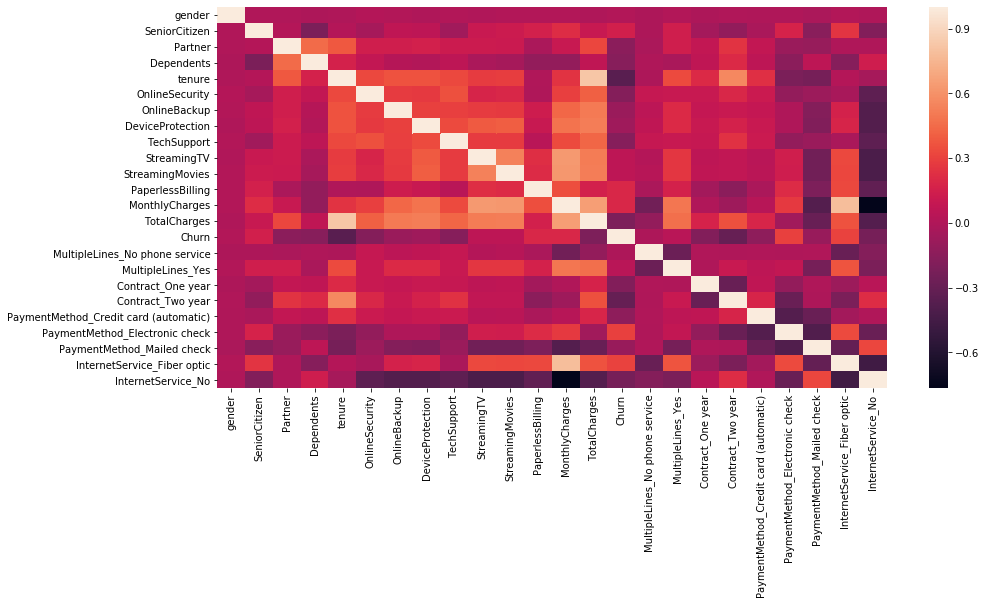

In [72]:
sns.heatmap(churn_hazard.corr())

In [73]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
partial log-likelihood = -12659.69
  time fit was run = 2019-07-31 14:33:38 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
gender                                 0.04      1.04      0.05           -0.05            0.13                0.95                1.14
SeniorCitizen                          0.03      1.04      0.06           -0.08            0.15                0.93                1.16
Partner                               -0.18      0.84      0.06           -0.29           -0.07                0.75                0.93
Dependents                            -0.09      0.91      0.07           -0.23            0.05                0.80                1.05
OnlineSecurity                        -0.21      0.81 

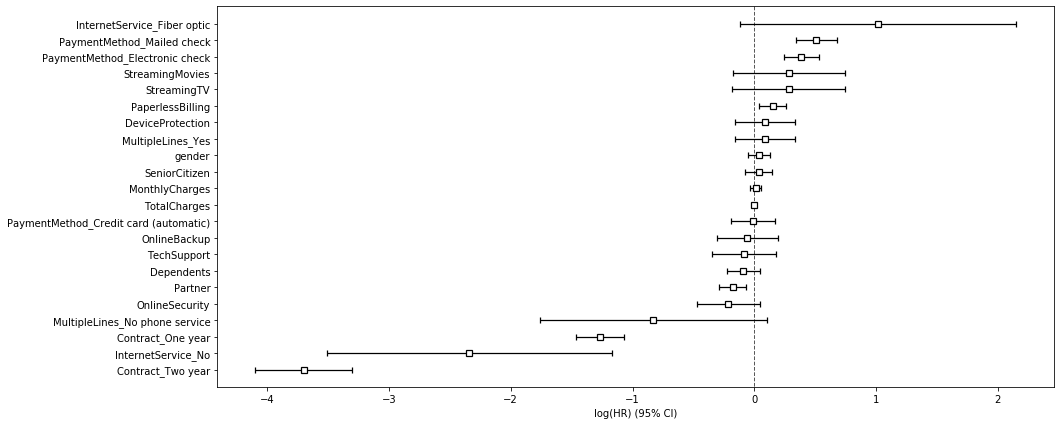

In [75]:
cph.plot()

In [84]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

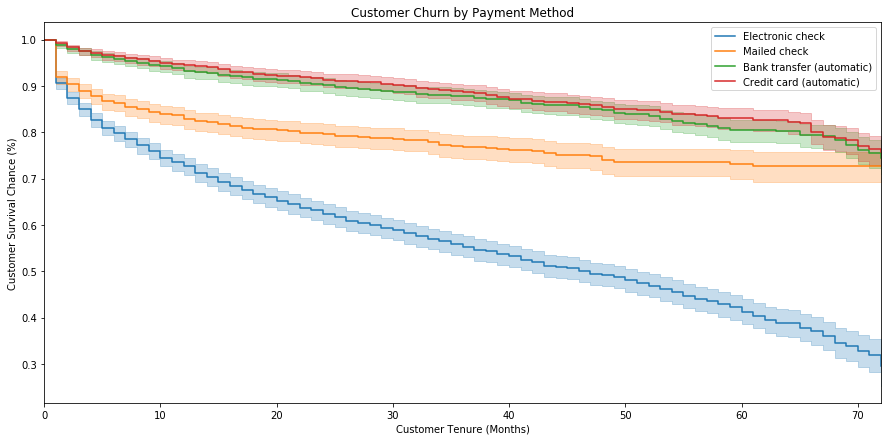

In [86]:
fig_pmt, ax_pmt = plt.subplots()
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()